In [2]:
!pip install -U openai-whisper
!pip install librosa numpy pandas matplotlib scikit-learn


Processing Sample 6 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 7 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 5 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 8 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 3 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 2 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 1 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Processing Sample 4 (1).wav...


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



Analysis Results:
               file   duration  word_count  sentence_count  speech_rate  \
0  Sample 6 (1).wav  18.356250          43               6     2.342526   
1  Sample 7 (1).wav  96.192000         160              26     1.663340   
2  Sample 5 (1).wav  10.042687          29               2     2.887673   
3  Sample 8 (1).wav   5.760000          13               2     2.256944   
4  Sample 3 (1).wav  10.042687          26               4     2.588948   
5  Sample 2 (1).wav  10.042687          35               3     3.485123   
6  Sample 1 (1).wav  10.042687          22               3     2.190649   
7  Sample 4 (1).wav  10.042687          26               3     2.588948   

   avg_words_per_sentence  hesitations  pause_count  pauses_per_sentence  \
0                7.166667            2           14             2.333333   
1                6.153846           11           44             1.692308   
2               14.500000            2            4             2.000000   
3

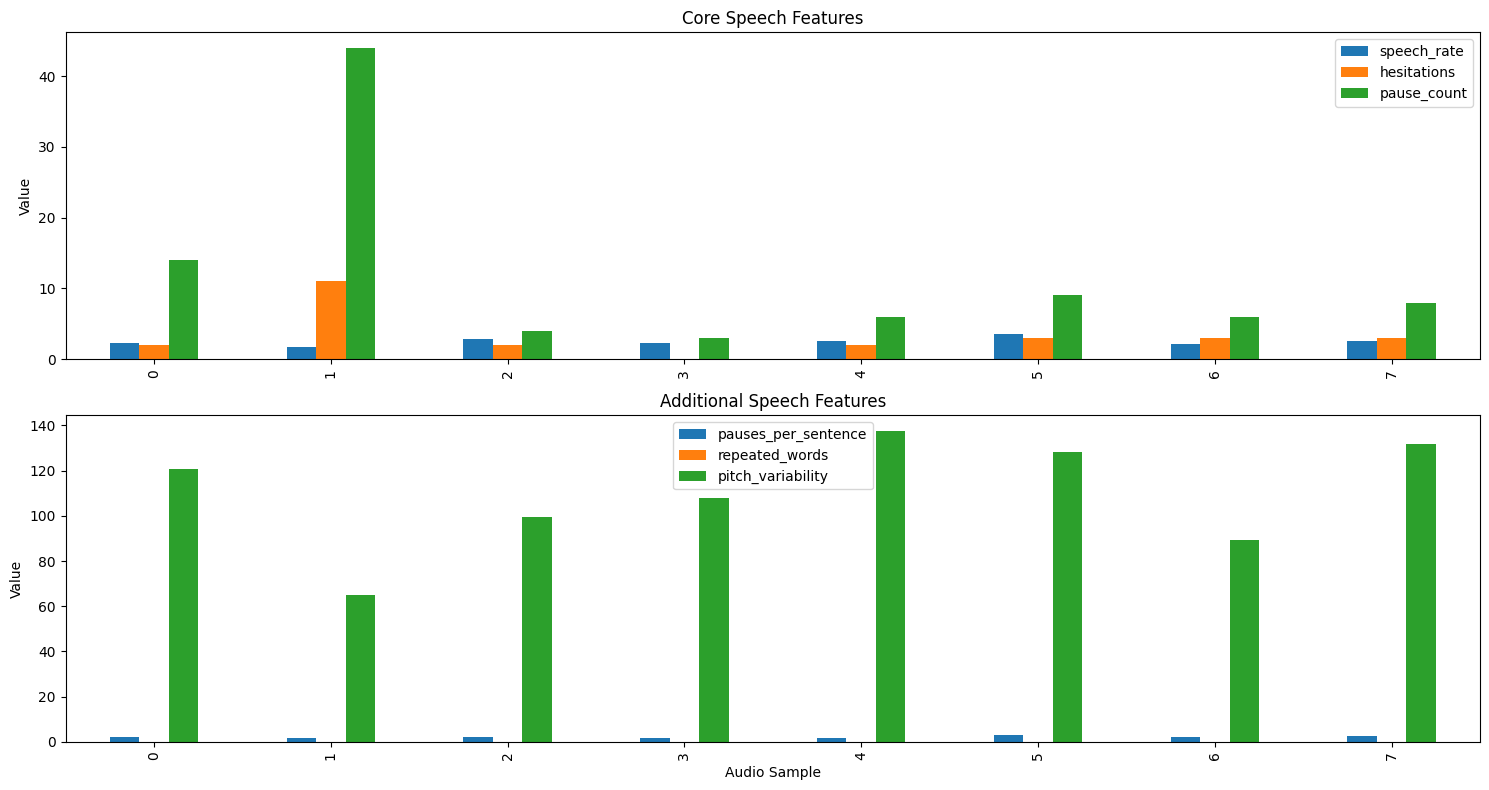

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import whisper
from sklearn.ensemble import IsolationForest

AUDIO_FOLDER = "/content/audio_samples"

def extract_features(audio_path):
    # Load audio
    y, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)

    # Speech transcription
    model = whisper.load_model("base")
    result = model.transcribe(audio_path)
    transcript = result["text"].lower()
    words = transcript.split()
    sentences = [s.strip() for s in transcript.split('.') if len(s.strip()) > 0]

    # Basic counts
    word_count = len(words)
    sentence_count = len(sentences)

    # Speech rate features
    speech_rate = word_count / duration if duration else 0
    avg_words_per_sentence = word_count / sentence_count if sentence_count else 0

    # Pause features
    pause_segments = librosa.effects.split(y, top_db=30)
    pause_count = len(pause_segments)
    pauses_per_sentence = pause_count / sentence_count if sentence_count else 0

    # Hesitation features
    hesitation_words = ["uh", "um", "ah", "er", "hm", "like", "you know"]
    hesitations = sum(transcript.count(word) for word in hesitation_words)

    # Word recall issues
    repeated_words = sum(1 for i in range(len(words)-1) if words[i] == words[i+1])
    unique_word_ratio = len(set(words)) / word_count if word_count else 0

    # Pitch variability
    pitches = librosa.yin(y, fmin=50, fmax=500)
    pitch_variability = np.std(pitches) if len(pitches) > 0 else 0

    # Naming/word-association approximation (using repeated words as proxy)
    naming_difficulty = repeated_words / word_count if word_count else 0

    return {
        "file": os.path.basename(audio_path),
        "duration": duration,
        "word_count": word_count,
        "sentence_count": sentence_count,
        "speech_rate": speech_rate,
        "avg_words_per_sentence": avg_words_per_sentence,
        "hesitations": hesitations,
        "pause_count": pause_count,
        "pauses_per_sentence": pauses_per_sentence,
        "repeated_words": repeated_words,
        "unique_word_ratio": unique_word_ratio,
        "pitch_variability": pitch_variability,
        "naming_difficulty": naming_difficulty
    }

def process_all_files():
    features = []
    for filename in os.listdir(AUDIO_FOLDER):
        if filename.endswith(".wav"):
            path = os.path.join(AUDIO_FOLDER, filename)
            print(f"Processing {filename}...")
            try:
                feats = extract_features(path)
                features.append(feats)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    return pd.DataFrame(features)

def detect_risk(df):
    model = IsolationForest(contamination=0.2, random_state=42)
    features = [
        "speech_rate",
        "hesitations",
        "pause_count",
        "pauses_per_sentence",
        "repeated_words",
        "pitch_variability",
        "naming_difficulty"
    ]
    X = df[features]
    df["risk"] = model.fit_predict(X)
    df["risk"] = df["risk"].map({1: "Normal", -1: "At Risk"})
    return df

def plot_results(df):
    # Plot speech features
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    df[["speech_rate", "hesitations", "pause_count"]].plot(kind="bar", ax=plt.gca())
    plt.title("Core Speech Features")
    plt.ylabel("Value")

    plt.subplot(2, 1, 2)
    df[["pauses_per_sentence", "repeated_words", "pitch_variability"]].plot(kind="bar", ax=plt.gca())
    plt.title("Additional Speech Features")
    plt.xlabel("Audio Sample")
    plt.ylabel("Value")

    plt.tight_layout()
    plt.savefig("speech_features_analysis.png")
    plt.show()

if not os.path.exists(AUDIO_FOLDER):
    print(f"Please upload audio files to {AUDIO_FOLDER} first")
else:
    df = process_all_files()
    if not df.empty:
        df = detect_risk(df)
        df.to_csv("speech_analysis_results.csv", index=False)
        print("\nAnalysis Results:")
        print(df)
        plot_results(df)
    else:
        print("No valid WAV audio files found to process")